In [198]:
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import re
import os
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import albumentations as augm
from albumentations.pytorch import ToTensorV2
import sklearn
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
import json

In [199]:
RANDOM_SEED = 11
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

<span style="color:blue; font-weight:bold; font-size:36px;"> Introduction </span>

This project is about gray matter segmentation in spinal cord MRIs.  
I wanted to create a project on my own, and I had this idea thanks to an internship I did few years ago at the CRMBM laboratory (Marseille, France), specialized in spinal cord MRI. Back then, I worked on a statistical method which aimed to detect pathologies such as ALS, but I did not use any Deep Learning method. However, I used several masks, and I was curious about segmentation.  

Gray matter in the spinal cord plays a crucial role in processing and transmitting nerve signals, particularly those involved in muscle control and sensory perception. Accurate segmentation of gray matter is important for diagnosing and tracking neurological diseases like multiple sclerosis, amyotrophic lateral sclerosis (ALS), and spinal cord injuries, where this region can be affected.

Thus, after few online researches, I found a spinal cord MRIs dataset allowing me to try to develop a model. This dataset was created as part of a segmentation challenge using several MRI scans from different laboratories and different modalities (F. Prados, J. Ashburner, C. Blaiotta, et al., " Spinal cord grey matter segmentation challenge", NeuroImage, Volume 152, 15 May 2017).

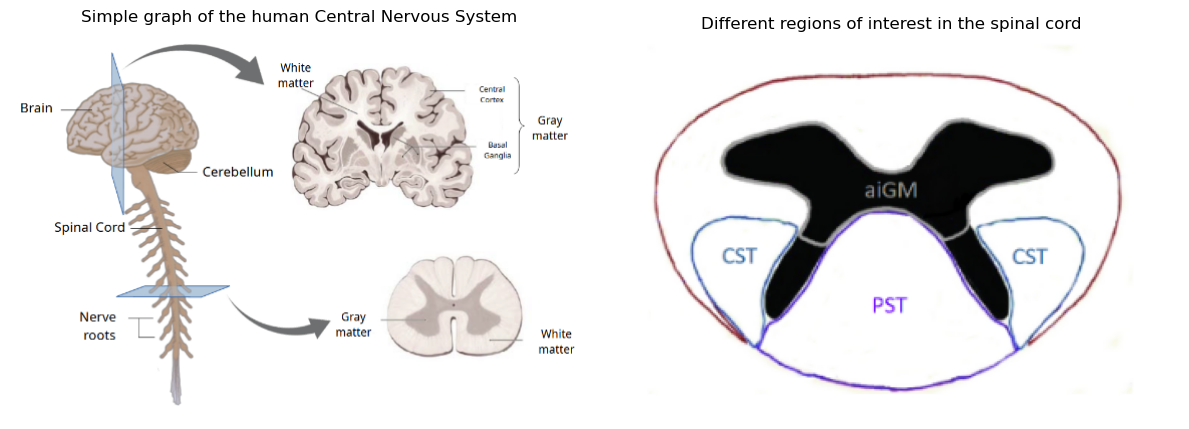

In [200]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1), plt.imshow(plt.imread('basic_illustrations/CNS.png')), plt.axis('off'), plt.title('Simple graph of the human Central Nervous System')
plt.subplot(1,2,2), plt.imshow(plt.imread('basic_illustrations/ROI.png')), plt.axis('off'), plt.title('Different regions of interest in the spinal cord')
plt.tight_layout()

Both illustrations are extracted from my internship report.

Now, to understand the project in details, it is necessary to have a basic understanding of the type of data manipulated. MRIs are often built from different slices, corresponding to various heights in the body. 

Finally, the last thing you need to know is that the spinal cord is located in the upper part of the spinal column, mainly in the cervical spine, illustrated in the picture below (https://www.flintrehab.com/cervical-spine-injury/). This is why we often speak of levels in MRI, corresponding to the cervical spine imaged.

Thus, to make the images easier to understand, each nifti file in the dataset is associated with a “level.txt” text file, in which the level of each slice is entered. 

(<Figure size 800x300 with 1 Axes>,
 (-0.5, 603.5, 501.5, -0.5),
 Text(0.5, 1.0, 'Cervical levels'))

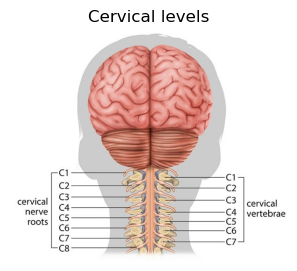

In [201]:
plt.figure(figsize=(8,3)), plt.imshow(plt.imread('basic_illustrations/c_levels.png')), plt.axis('off'), plt.title('Cervical levels')

<span style="color:blue; font-weight:bold; font-size:36px;"> Data Exploration </span>

As usual for these kind of data, MRIs are stored in nifti format, allowing to contain every slice of an acquisition in one file.
Thus, we have to use a function (included in the nibabel library) allowing to read these files, and returning each slice of the MRI.

In [202]:
def load_nifti_image(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

As explained in the introduction, MRIs come from 4 different sites : University College London (UCL), Ecole Polytechnique de Montreal (EPM), Vanderbilt University (VDB), University Hospital Zurich (UHZ).  

<span style="color:orange; font-weight:bold; font-size:30px;"> MRI </span>

To get an idea of the nature of the images, we going to display a slice of an MRI (arbitrarily chosen) for each site, so as to explain some of their specifics.

<span style="color:green; font-weight:bold; font-size:24px;"> Site 1 </span>

In [203]:
img_test1 = load_nifti_image('./train/site1-sc01-image.nii.gz')
img_test1.shape

(100, 100, 3)

Here, the MRI contains 3 (100x100) slices, corresponding to different levels of the cord. According to the levels files, images correspond to the spine between cervicals 2 and 3.

Text(0.5, 1.0, 'MRI from site 1')

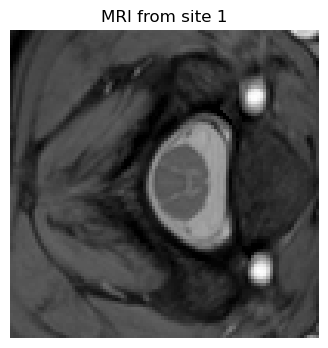

In [204]:
plt.figure(figsize=(10,4))
plt.imshow(img_test1[:,:,0], cmap='gray') # We plot the 1st slice of the MRI
plt.axis('off')
plt.title('MRI from site 1')

Like in this example, every image from this site are centered around the gray matter (the horizontal 'H' shape).

<span style="color:green; font-weight:bold; font-size:24px;"> Site 2</span> 

In [205]:
img_test2 = load_nifti_image('./train/site2-sc06-image.nii.gz')
img_test2.shape

(320, 320, 13)

Most of the MRIs from this site contains 13 slices (320x320), distributed over all the cervical levels (from C1 to C7), but some of them only contains less slices, corresponding only to upper levels. 

Text(0.5, 1.0, 'MRI from site 2')

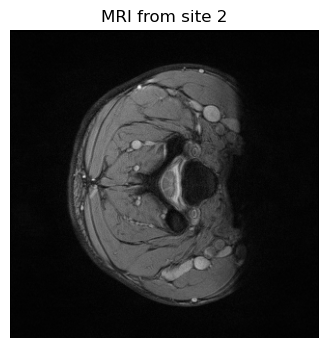

In [206]:
plt.figure(figsize=(10,4))
plt.imshow(img_test2[:,:,5], cmap='gray') # We plot the 6th slice of the MRI
plt.axis('off')
plt.title('MRI from site 2')

On this slice, we can see that the whole structure is represented, not only the spinal cord. Thus, the key information is dilated.

<span style="color:green; font-weight:bold; font-size:24px;"> Site 3</span>

In [207]:
img_test3 = load_nifti_image('./train/site3-sc01-image.nii.gz')
img_test3.shape

(654, 774, 28)

MRIs from the third site contain 28 slices, which are not squared (654x774). Slices are distributed over all the cervical levels.

Text(0.5, 1.0, 'MRI from site 3')

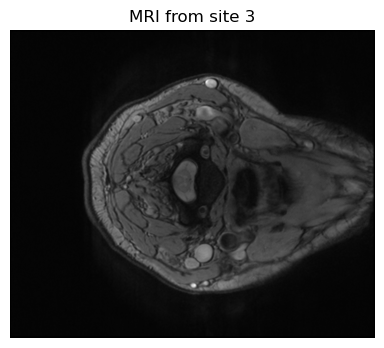

In [208]:
plt.figure(figsize=(10,4))
plt.imshow(img_test3[:,:,11], cmap='gray') # We plot the 12th slice of the MRI
plt.axis('off')
plt.title('MRI from site 3')

Like in the previous site, the whole structure has been imaged here. Moreover, we can easily notice that there is a distortion artifact at the right of the picture, which is more or less pronounced depending on the slice selected.

### Site 4

In [209]:
img_test4 = load_nifti_image('./train/site4-sc02-image.nii.gz')
img_test4.shape

(560, 560, 14)

In the last site, MRIs contain from 12 to 14 slices (560x560), corresponding to C2-C6 levels.

Text(0.5, 1.0, 'MRI from site 4')

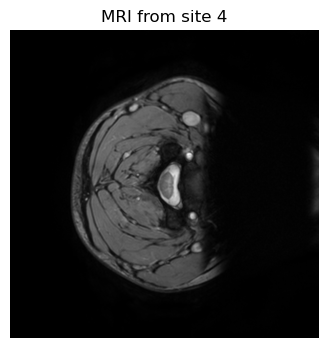

In [210]:
plt.figure(figsize=(10,4))
plt.imshow(img_test4[:,:,6], cmap='gray') # We plot the 7th slice of the MRI
plt.axis('off')
plt.title('MRI from site 4')

Like in the two previous sites, the whole structured is represented, but this one is really zoomed out. The cord is easilly identifiable, but the region of interest is really small.

<span style="color:orange; font-weight:bold; font-size:30px;"> Masks </span>

Now, we can display a mask example (also arbitrarily chosen) to look what it is like.

(<Axes: title={'center': 'Zoomed associated mask'}>,
 (-0.5, 79.5, 79.5, -0.5),
 Text(0.5, 1.0, 'Zoomed associated mask'))

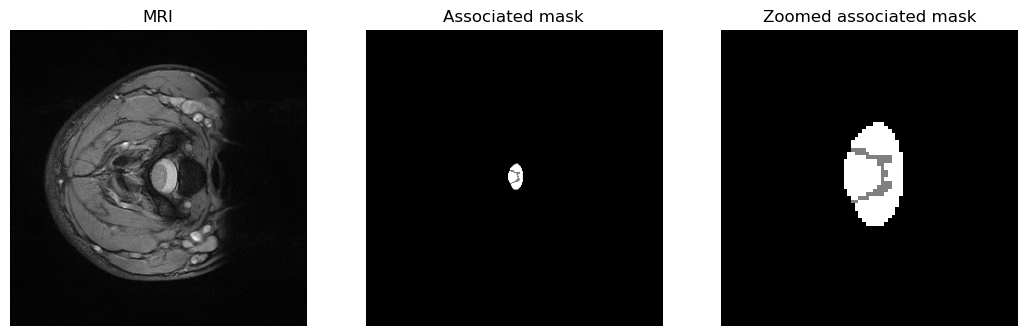

In [211]:
mri = load_nifti_image('./train/site2-sc01-image.nii.gz')[:,:,5]
mask = load_nifti_image('./train/site2-sc01-mask-r1.nii.gz')[:,:,5]
plt.figure(figsize=(13,5))
plt.subplot(1,3,1), plt.imshow(mri, cmap='gray'), plt.axis('off'), plt.title('MRI')
plt.subplot(1,3,2), plt.imshow(mask, cmap='gray'), plt.axis('off'), plt.title('Associated mask')
plt.subplot(1,3,3), plt.imshow(mask[120:200, 120:200], cmap='gray'), plt.axis('off'), plt.title('Zoomed associated mask')


The mask is divided into 3 categories: 
- White pixels (=2), corresponding to the white matter in spinal cord  
- Gray pixels (=1), corresponding to the gray matter in spinal cord, our region of interest  
- Black pixels (=0), corresponding to the background

<span style="color:blue; font-weight:bold; font-size:36px;"> Data processing </span>

First, we want to get rid off the white matter which will not be useful in the approach I used. To do so, we binarize the masks with pixels belonging to the gray matter equal to one, others equal to 0.

In [212]:
def binarize(mask):
    binarized_mask = np.zeros(mask.shape)
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if mask[x,y] == 1:
                binarized_mask[x,y] = 1
            else:
                pass
    return binarized_mask

In the dataset, each MRI is associated with 4 different masks, segmented by 4 different experts. We then calculate a majority mask: if at least three experts agree that a pixel belongs to gray matter, then it will belong to the majority mask we construct. 

In [213]:
def majoritary_mask(masks_paths):
    mask1 = load_nifti_image(masks_paths[0])
    mask2 = load_nifti_image(masks_paths[1])
    mask3 = load_nifti_image(masks_paths[2])
    mask4 = load_nifti_image(masks_paths[3])
    mask_majoritary_vote = []
    for slice in range(mask1.shape[2]):
        binary_slice_mask1 = binarize(mask1[:,:,slice])
        binary_slice_mask2 = binarize(mask2[:,:,slice])
        binary_slice_mask3 = binarize(mask3[:,:,slice])
        binary_slice_mask4 = binarize(mask4[:,:,slice])
        sum_binary_slice = binary_slice_mask1 + binary_slice_mask2 + binary_slice_mask3 + binary_slice_mask4
        binary_slice = (sum_binary_slice>2).astype('uint8')
        mask_majoritary_vote.append(binary_slice)
    return np.moveaxis(np.array(mask_majoritary_vote), 0, -1)

The next step is to process the images so that they all look the same. To do this, we crop each image around the area of interest, as was already done for the MRIs from the first site.  

However, it is essential not to systematically center the image on gray matter, as this could introduce a geographical bias when automating segmentation. This is why we introduce a random shift in each cropping.
The resizing operations are different for each site, hence the introduction of the parameters SIZE_SQUARE and MAX_SHIFT, allowing to obtain similar images regardless of acquisition modalities.

In [214]:
def extract_mask_extrema(binary_mask):
    indices = np.argwhere(binary_mask == 1)
    xmin = np.min(indices[:,1])
    xmax = np.max(indices[:,1])
    ymin = np.max(indices[:,0])
    ymax = np.min(indices[:,0])
    return (xmin, xmax-xmin, ymax, ymin-ymax)

In [215]:
def crop_image_around_the_mask(img, binary_mask, SIZE_SQUARE=100, MAX_SHIFT=30):
    (x, w, y, h) = extract_mask_extrema(binary_mask)
    width_to_add = round((SIZE_SQUARE - w) / 2)
    height_to_add = round((SIZE_SQUARE - h) / 2)

    shift_x = np.random.randint(-MAX_SHIFT, MAX_SHIFT)
    shift_y = np.random.randint(-MAX_SHIFT, MAX_SHIFT)

    y_min = max(0, y - height_to_add + shift_y)
    y_max = min(img.shape[0], y + height_to_add + h + shift_y)
    x_min = max(0, x - width_to_add + shift_x)
    x_max = min(img.shape[1], x + width_to_add + w + shift_x)
    if (y_max - y_min) != SIZE_SQUARE:
        if y_min == 0:
            y_max = SIZE_SQUARE
        else:
            y_min = y_max - SIZE_SQUARE
    if (x_max - x_min) != SIZE_SQUARE:
        if x_min == 0:
            x_max = SIZE_SQUARE
        else:
            x_min = x_max - SIZE_SQUARE

    cropped_img = img[y_min:y_max, x_min:x_max]
    cropped_mask = binary_mask[y_min:y_max, x_min:x_max]
    return cropped_img, cropped_mask

Then I thought it would be a good idea to associate each slice with the corresponding level.   
To do this, we extract the levels from each text file. Here is an example of a level file:

*slice#, level*   
*13, 2+*  
*12, 2*  
*11, 2*  
*10, 2/3*    
*9, 3*  
*8, 3*  
*7, 3/4*   
*6, 4*  
*5, 4*     
*4, 4/5*       
*3, 5*     
*2, 5*  
*1, 5/6*   
*0, 6*   

On the left column, there is the index of the slice, and on the right the level associated. The level is often encoded by an integer, or two when the slice corresponds to the interface between two cervicals. Sometimes, the level is indicated by a hyphen. In this case, the None value is associated with the slice level.

In [216]:
def get_levels(filename):
    list_levels = []
    with open(filename, 'r') as file:
        lines = file.readlines()
    for line in lines[1:]:
        try:
            levels_in_file = re.findall('(,)(.*)', line)[0][1]
            list_levels.append(int(levels_in_file.strip()[0]))
        except:
            list_levels.append(None)
    return list_levels

To facilitate future data processing, we create a dictionary in which all useful information are entered.

In [217]:
dict_filepaths={}
filename_img = []
filename_levels = []
filename_masks = []
for site_index in range(1,5):
    for irm_index in range(1,11):
        if irm_index < 10:
            name_index = '0' + str(irm_index)
        else:
            name_index = '10'
        filename_img.append('./train/site'+str(site_index)+'-sc'+name_index+'-image.nii.gz')
        filename_levels.append('./train/site'+str(site_index)+'-sc'+name_index+'-levels.txt')
        filename_masks.append(['./train/site'+str(site_index)+'-sc'+name_index+'-mask-r'+str(i)+'.nii.gz' for i in range(1,5)])

In [218]:
for k in range(len(filename_img)):
    dict_filepaths['MRI'+str(k)]={
            'site' : int(filename_img[k][12:13]),
            'filename_img' : filename_img[k],
            'filename_levels' : filename_levels[k],
            'filename_masks' : filename_masks[k]
    }

In [219]:
dict_filepaths['MRI0']

{'site': 1,
 'filename_img': './train/site1-sc01-image.nii.gz',
 'filename_levels': './train/site1-sc01-levels.txt',
 'filename_masks': ['./train/site1-sc01-mask-r1.nii.gz',
  './train/site1-sc01-mask-r2.nii.gz',
  './train/site1-sc01-mask-r3.nii.gz',
  './train/site1-sc01-mask-r4.nii.gz']}

Sometimes, some MRI slices are null, and need to be removed so as not to interfere with training. Here, we make a double check: we remove each slice which associated level is None, and each slice containing only black pixels.  
First, we had to modify some “levels.txt” files that contained a different number of slices than the actual mask. For instance, a text file could indicate 11 slices, while the mask shape was only (x,y,10).

We highlighted these anomalies thanks to the following block of code, then manually corrected the text files concerned.

In [220]:
# # Manual corrections of level/slice index issue
# for k in range(0,40):
#     name_mri = 'MRI'+str(k)
#     mri = load_nifti_image(dict_filepaths[name_mri]['filename_img'])
#     levels = get_levels(dict_filepaths[name_mri]['filename_levels'])
#     for ind in range(4):
#         if len(levels)!=load_nifti_image(dict_filepaths[name_mri]['filename_masks'][0]).shape[2]:
#             print (f'{k} : {dict_filepaths[name_mri]['filename_levels']} : Levels len = {len(levels)}, Mask shape = {load_nifti_image(dict_filepaths[name_mri]['filename_masks'][0]).shape}')

In [221]:
def remove_null_image(mri, mask, levels):
    (x,y,_) = mri.shape
    levels_without_none = []
    mri_without_null = []
    mask_without_null = []
    for i in range(len(levels)):
        if levels[i] is None or np.array_equal(mask[:,:,i], np.zeros((x,y))):
            pass
        else:
            levels_without_none.append(levels[i])
            mri_without_null.append(mri[:,:,i])
            mask_without_null.append(mask[:,:,i])
    return np.moveaxis(np.array(mri_without_null), 0, -1), np.moveaxis(np.array(mask_without_null), 0, -1), levels_without_none

At this point, all that remains is to save each slice as an individual file.

In [222]:
def load_mri_slices(dict_filepaths, MRI_index):
    name_mri = 'MRI'+str(MRI_index)
    mri = load_nifti_image(dict_filepaths[name_mri]['filename_img'])
    levels = get_levels(dict_filepaths[name_mri]['filename_levels'])
    mask = majoritary_mask(dict_filepaths[name_mri]['filename_masks'])
    mri_formated, mask_formated, levels_formated = remove_null_image(mri, mask, levels)
    return mri_formated, mask_formated, levels_formated

In [223]:
MRI_SLICES_PATH = './data_formated/MRI_slices/'
MASK_SLICES_PATH = './data_formated/masks_slices/'
def save_slice_as_single_file(dict_filepaths, index, filepath_slices_mri = MRI_SLICES_PATH, filepath_slices_masks = MASK_SLICES_PATH):
    cropping_factors = [[500,1],[100,30],[200,60],[150,55]]
    cropping_index = index//10
    mri, mask, levels = load_mri_slices(dict_filepaths, index)
    os.makedirs(filepath_slices_mri, exist_ok=True)
    os.makedirs(filepath_slices_masks, exist_ok=True)
    (_,_,nb_slices) = mri.shape
    for slice_index in range(nb_slices):
        mask_slice = mask[:,:,slice_index]
        binary_mask_slice = binarize(mask_slice)
        mri_slice = mri[:,:,slice_index]

        mri_slice_formated, mask_slice_formated = crop_image_around_the_mask(mri_slice, binary_mask_slice, SIZE_SQUARE=cropping_factors[cropping_index][0], MAX_SHIFT=cropping_factors[cropping_index][1])

        mri_slice_formated = cv2.resize(mri_slice_formated, (256,256), interpolation=cv2.INTER_LINEAR)
        mask_slice_formated = cv2.resize(mask_slice_formated, (256,256), interpolation=cv2.INTER_LINEAR)

        np.save(os.path.join(filepath_slices_mri, f'IRM{index}_slice_{slice_index}.npy'), mri_slice_formated)
        np.save(os.path.join(filepath_slices_masks, f'Mask{index}_slice_{slice_index}.npy'), mask_slice_formated)

In [224]:
# for mri_index_in_dict in range(len(dict_filepaths)):
#     save_slice_as_single_file(dict_filepaths, mri_index_in_dict)

To check that the generated images match the masks, we display a sample of each site.

In [225]:
def plot_sample(index):
    mri_array = np.load('./data_formated/MRI_slices/IRM'+str(index)+'_slice_0.npy')
    mask_array = np.load('./data_formated/masks_slices/Mask'+str(index)+'_slice_0.npy')
    plt.subplot(1,2,1)
    plt.imshow(mri_array, cmap='gray')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(mask_array, cmap='gray')
    plt.axis('off')

Text(0.5, 1.0, 'Site 4')

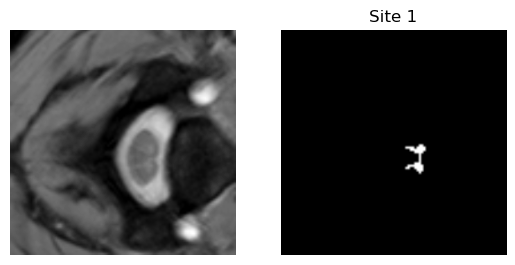

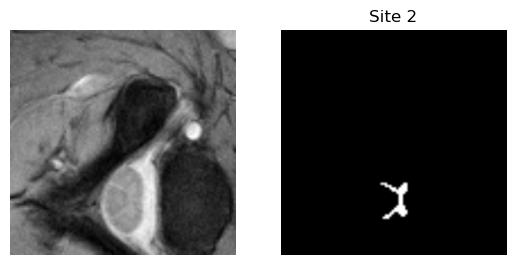

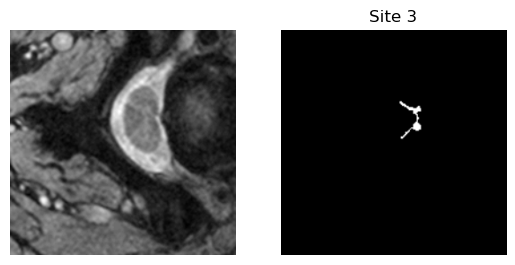

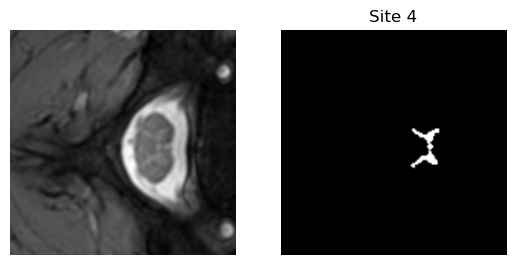

In [226]:
index1=np.random.randint(0,10)
index2=np.random.randint(10,20)
index3=np.random.randint(20,30)
index4=np.random.randint(30,40)
plt.figure()
plot_sample(index1)
plt.title('Site 1')
plt.figure()
plot_sample(index2)
plt.title('Site 2')
plt.figure()
plot_sample(index3)
plt.title('Site 3')
plt.figure()
plot_sample(index4)
plt.title('Site 4')

On the one hand, this display allows us to check that the MRIs for each site have a similar appearance after our processing, and that the correspondence between mask and image is preserved.

We check one more time that every mask is valid, meaning that they are not null.

In [227]:
for file in os.scandir('./data_formated/masks_slices/'):
    img = np.load(file.path)
    if np.array_equal(img, np.zeros((256,256))):
        print(f'Bad mask, file {file.path}')

<span style="color:blue; font-weight:bold; font-size:36px;"> Dataset creation </span>

Now we create a dataset that Pytorch can use to load each of the files generated above.

In [228]:
class SpinalCordDataset(Dataset):
    def __init__(self, irm_slices_path, mask_slices_path, transform = None):
        self.irm_slices_path = irm_slices_path
        self.mask_slices_path = mask_slices_path
        self.transform = transform

        self.irm_files = [f for f in os.listdir(irm_slices_path) if f.startswith("IRM") and f.endswith(".npy")]
        self.data_pairs = []
        for irm_file in self.irm_files:
            mask_file = 'Mask' + irm_file[3:]
            self.data_pairs.append((irm_file, mask_file))

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        irm_file, mask_file = self.data_pairs[idx]
        irm_path = os.path.join(self.irm_slices_path, irm_file)
        mask_path = os.path.join(self.mask_slices_path, mask_file)

        irm = np.load(irm_path)
        mask = np.load(mask_path)

        irm = (irm - irm.min()) / (irm.max() - irm.min())
        irm_uint8 = (irm * 255).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=irm_uint8, mask=mask)
            irm_tensor = augmented['image']
            mask_tensor = augmented['mask']
        else:
            irm_tensor = torch.from_numpy(irm).float().unsqueeze(0)
            mask_tensor = torch.from_numpy(mask).long()

        return irm_tensor, mask_tensor

In [229]:
# from google.colab import drive
# drive.mount('/content/drive')

To compensate for the low total number of images (448), we use data augmentation:   
- Contrast Limited Adaptative Histogram Equalization (CLAHE), used to enhance contrast in images  
- GaussNoise, to simulate Gaussian noise that may appear during acquisitions  
- RandomRotate90, to rotate certain images by 90° in order to train the model on different orientations    

Next, we separate the data into training, validation and test sets. Images are normalized, but only the ones from the training set are transformed as decribed above.  

Finally, we load each set into dataloaders, easily usable by the Pytorch model we will build.

In [230]:
# irm_slices_path = '/content/drive/MyDrive/Colab Notebooks/data_formated/MRI_slices'
# mask_slices_path =  '/content/drive/MyDrive/Colab Notebooks/data_formated/masks_slices'

irm_slices_path = 'data_formated/MRI_slices'
mask_slices_path =  'data_formated/masks_slices'

train_transform = augm.Compose([
    augm.CLAHE(clip_limit=4.0, tile_grid_size=(8,8), p=0.3),
    augm.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    augm.RandomRotate90(p=0.33),
    augm.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
])

test_transform = augm.Compose([
    augm.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
])

dataset = SpinalCordDataset(irm_slices_path, mask_slices_path)  

train_val_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.15, random_state=RANDOM_SEED)
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.175, random_state=RANDOM_SEED) 

train_dataset = SpinalCordDataset(irm_slices_path, mask_slices_path, transform=train_transform)
val_dataset = SpinalCordDataset(irm_slices_path, mask_slices_path, transform=test_transform) 
test_dataset = SpinalCordDataset(irm_slices_path, mask_slices_path, transform=test_transform)

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(val_dataset, val_indices)
test_subset = torch.utils.data.Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=2, shuffle=False)

<span style="color:blue; font-weight:bold; font-size:36px;"> Model conception </span>

To address this segmentation task, we implement a U-Net model, which is frequently used in this context. Its architecture is illustrated by the figure below (coming from the following article: O. Ronneberger, P. Fischer, T. Brox, "U-Net: Convolutional Networks for Biomedical Image Segmentation", Medical Image Computing and Computer-Assisted Intervention (MICCAI) (2015)).

(<Figure size 2000x800 with 1 Axes>,
 (-0.5, 1271.5, 845.5, -0.5),
 Text(0.5, 1.0, 'U-Net Architecture'))

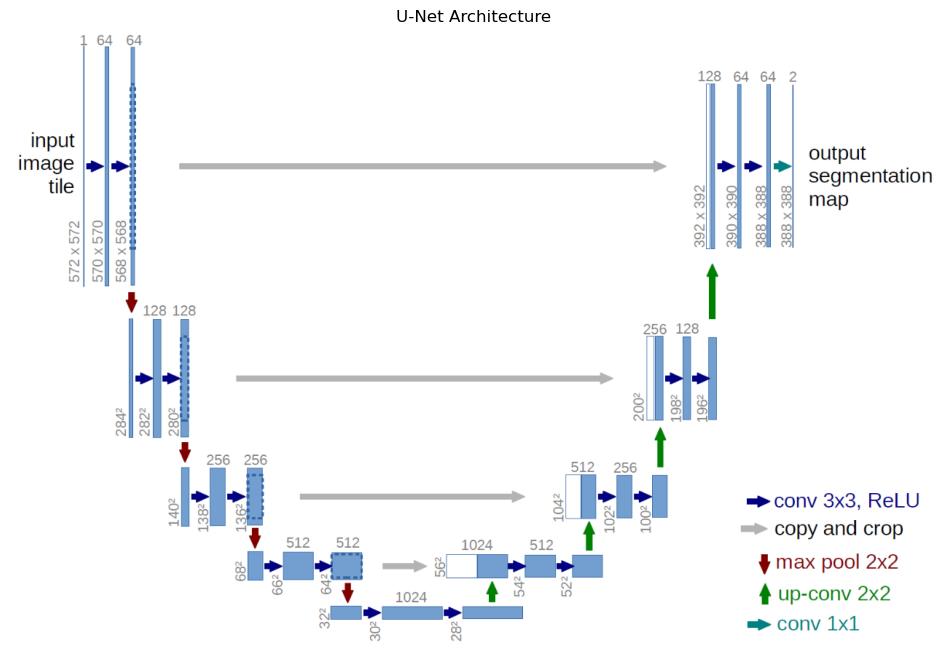

In [231]:
plt.figure(figsize=(20,8)), plt.imshow(plt.imread('basic_illustrations/u_net.png')), plt.axis('off'), plt.title('U-Net Architecture')

To keep it simple, U-Net is a convolutional neural network architecture designed for image segmentation tasks. It consists of two main parts: a contracting path (encoder) that captures contextual information by progressively reducing the image resolution, and an expansive path (decoder) that reconstructs the segmented image by increasing the resolution. Skip connections between the encoder and decoder allow the model to retain fine details that would otherwise be lost during downsampling. 

<span style="color:orange; font-weight:bold; font-size:30px;"> Model implementation </span>

In [232]:
class bloc_convo(nn.Module):
    def __init__(self, input_size, hidden_size = 64, output_size = 64, bool_first_block = False):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.bool_first_block = bool_first_block

        self.activation = nn.ReLU()

        self.dropout = nn.Dropout(0.5)

        self.MaxPooling = nn.MaxPool2d(kernel_size = (2,2))

        self.CNN1 = nn.Conv2d(
            in_channels = self.input_size,
            out_channels = self.hidden_size,
            kernel_size = (3,3),
            padding =(1,1))

        self.CNN2 = nn.Conv2d(
            in_channels = self.hidden_size,
            out_channels = self.output_size,
            kernel_size = (3,3),
            padding =(1,1))

    def forward(self, x):
        if not self.bool_first_block:
            x = self.MaxPooling(x)
        x = self.CNN1(x)
        x = self.activation(x)
        x = self.CNN2(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x

In [233]:
class bloc_deconvo(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bool_last_block = False):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.bool_last_block = bool_last_block

        self.activation = nn.ReLU()

        self.dropout = nn.Dropout(0.5)

        self.Deconvo1 = nn.ConvTranspose2d(
                in_channels = self.input_size,
                out_channels = self.hidden_size,
                kernel_size = (2,2),
                stride=2)

        self.CNN1 = nn.Conv2d(
            in_channels = 2 * self.hidden_size,
            out_channels = self.hidden_size,
            kernel_size = (3,3),
            padding =(1,1))

        self.CNN2 = nn.Conv2d(
            in_channels = self.hidden_size,
            out_channels = self.output_size,
            kernel_size = (3,3),
            padding =(1,1))

        self.CNN3 = nn.Conv2d(
            in_channels = self.hidden_size,
            out_channels = 1,
            kernel_size = (1,1))


    def forward(self, x, skip_connection):

        # if x.size()[2:] != skip_connection.size()[2:]:  
        #     skip_connection = nn.functional.interpolate(skip_connection, size=x.size()[2:], mode='bilinear', align_corners=True)

        x = self.Deconvo1(x)
        x = torch.concat([x, skip_connection], dim=1)
        x = self.CNN1(x)
        x = self.activation(x)
        x = self.CNN2(x)
        x = self.activation(x)
        x = self.dropout(x)
        if self.bool_last_block:
            x = self.CNN3(x)

        return x

In [234]:
class U_net_model(nn.Module):
    def __init__(self):
        super().__init__()

        self.bloc_convo1 = bloc_convo(input_size=1, hidden_size=64, output_size=64, bool_first_block=True)
        self.bloc_convo2 = bloc_convo(input_size=64, hidden_size=128, output_size=128)
        self.bloc_convo3 = bloc_convo(input_size=128, hidden_size=256, output_size=256)
        self.bloc_convo4 = bloc_convo(input_size=256, hidden_size=512, output_size=512)

        self.bloc_deconvo1 = bloc_deconvo(input_size=512, hidden_size=256, output_size=256)
        self.bloc_deconvo2 = bloc_deconvo(input_size=256, hidden_size=128, output_size=128)
        self.bloc_deconvo3 = bloc_deconvo(input_size=128, hidden_size=64, output_size=64, bool_last_block=True)

    def forward(self, x):
        skip_connection1 = self.bloc_convo1.forward(x)
        skip_connection2 = self.bloc_convo2.forward(skip_connection1)
        skip_connection3 = self.bloc_convo3.forward(skip_connection2)
        x = self.bloc_convo4.forward(skip_connection3)
        x = self.bloc_deconvo1.forward(x, skip_connection3)
        x = self.bloc_deconvo2.forward(x, skip_connection2)
        x = self.bloc_deconvo3.forward(x, skip_connection1)
        return x

In [235]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = U_net_model()
model = model.to(device)

cpu


To follow the model's performances during the training, we combine the Intersection over Union metric (IoU) and a binary crossentropy (bce) as a loss function. The IoU will be the metric allowing to measure the model's accuracy.

In [236]:
class IoU_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, prediction, actual_mask):
        pred_flat = torch.flatten(prediction)
        mask_flat = torch.flatten(actual_mask)

        intersection = torch.sum(pred_flat * mask_flat)
        union = torch.sum(pred_flat + mask_flat) - intersection

        return 1 - ((intersection + 1e-6 )/ (union + 1e-6))

In [237]:
def compute_iou(pred_mask, true_mask):
    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum(pred_mask) + torch.sum(true_mask) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

In [238]:
class CombinedLoss(nn.Module):
    def __init__(self, pos_weight=None):
        super().__init__()
        if pos_weight is not None:
            self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        else:
            self.bce = nn.BCEWithLogitsLoss()

    def forward(self, prediction, actual_mask):
        if len(actual_mask.shape) == len(prediction.shape) - 1:
            actual_mask = actual_mask.unsqueeze(1)
        bce_loss = self.bce(prediction, actual_mask)

        pred_flat = torch.flatten(torch.sigmoid(prediction))
        mask_flat = torch.flatten(actual_mask)

        intersection = torch.sum(pred_flat * mask_flat)
        union = torch.sum(pred_flat + mask_flat) - intersection
        iou_loss = 1 - ((intersection + 1e-6) / (union + 1e-6))

        return bce_loss + iou_loss

def compute_pos_weight(dataloader):
    total_positives = 0
    total_negatives = 0

    for images, masks in dataloader:
        total_positives += torch.sum(masks == 1).item()
        total_negatives += torch.sum(masks == 0).item()

    pos_weight_value = total_negatives / (total_positives + 1e-6)
    pos_weight = torch.tensor([pos_weight_value], device=device)

    return pos_weight

Finally, after a first training, I noticed that the predicted masks were too dilatated, so I introduced an erosion step on the mask in order to improve the quality of the result. However, at this stage, I did not know how many times did I need to erode the predicted mask in order to optimize the IoU, so I tried eroding it once, twice and three times.

In [239]:
def erode_masks(output_probs, kernel_size=3, iterations=1, threshold=0.5):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_masks = []

    for i in range(output_probs.shape[0]):
        pred = (output_probs[i, 0].cpu().numpy() > threshold).astype(np.uint8) * 255
        eroded = cv2.erode(pred, kernel, iterations=iterations)
        eroded_masks.append(eroded.astype(np.float32) / 255)
    eroded_masks_tensor = torch.tensor(np.array(eroded_masks)).unsqueeze(1).to(output_probs.device)
    return eroded_masks_tensor

<span style="color:orange; font-weight:bold; font-size:30px;"> Model training </span>

In [240]:
def train_model(model, train_dataloader, val_dataloader, epochs):
    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []
    train_ious_er1 = []
    val_ious_er1 = []
    train_ious_er2 = []
    val_ious_er2 = []
    train_ious_er3 = []
    val_ious_er3 = []

    pos_weight = compute_pos_weight(train_dataloader)
    criterion = CombinedLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    best_val_loss = float("inf")
    best_model = None

    for epoch in range(epochs):
        tr_losses_epoch = []
        tr_iou_epoch = []
        val_losses_epoch = []
        val_iou_epoch = []
        tr_ious_er1_epoch = []
        val_ious_er1_epoch = []
        tr_ious_er2_epoch = []
        val_ious_er2_epoch = []
        tr_ious_er3_epoch = []
        val_ious_er3_epoch = []

        model = model.train()
        for batch in train_dataloader:
            optimizer.zero_grad()
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
            pred = model(images)
            loss = criterion(pred, masks)
            tr_losses_epoch.append(loss.item())

            pred_mask = (torch.sigmoid(pred) > 0.5).float()
            iou = compute_iou(pred_mask, masks)
            tr_iou_epoch.append(iou.item())

            erod_masks1 = erode_masks(pred_mask, iterations=1)
            iou_er1 = compute_iou(erod_masks1, masks)
            tr_ious_er1_epoch.append(iou_er1.item())

            erod_masks2 = erode_masks(pred_mask, iterations=2)
            iou_er2 = compute_iou(erod_masks2, masks)
            tr_ious_er2_epoch.append(iou_er2.item())

            erod_masks3 = erode_masks(pred_mask, iterations=3)
            iou_er3 = compute_iou(erod_masks3, masks)
            tr_ious_er3_epoch.append(iou_er3.item())

            loss.backward()
            optimizer.step()

        model = model.eval()
        with torch.no_grad():
            for batch_val in val_dataloader:
                image_val = batch_val[0].to(device)
                mask_val = batch_val[1].to(device)
                pred_val = model.forward(image_val)
                loss_val = criterion(pred_val, mask_val)
                val_losses_epoch.append(loss_val.item())

                pred_val_mask = (torch.sigmoid(pred_val) > 0.5).float()

                val_iou = compute_iou(pred_val_mask, mask_val)
                val_iou_epoch.append(val_iou.item())

                erod_masks1_val = erode_masks(pred_val_mask, iterations=1)
                iou_er1_val = compute_iou(erod_masks1_val, mask_val)
                val_ious_er1_epoch.append(iou_er1_val.item())

                erod_masks2_val = erode_masks(pred_val_mask, iterations=2)
                iou_er2_val = compute_iou(erod_masks2_val, mask_val)
                val_ious_er2_epoch.append(iou_er2_val.item())

                erod_masks3_val = erode_masks(pred_val_mask, iterations=3)
                iou_er3_val = compute_iou(erod_masks3_val, mask_val)
                val_ious_er3_epoch.append(iou_er3_val.item())

        train_losses.append(np.mean(tr_losses_epoch))
        val_losses.append(np.mean(val_losses_epoch))
        train_ious.append(np.mean(tr_iou_epoch))
        val_ious.append(np.mean(val_iou_epoch))
        train_ious_er1.append(np.mean(tr_ious_er1_epoch))
        train_ious_er2.append(np.mean(tr_ious_er2_epoch))
        train_ious_er3.append(np.mean(tr_ious_er3_epoch))
        val_ious_er1.append(np.mean(val_ious_er1_epoch))
        val_ious_er2.append(np.mean(val_ious_er2_epoch))
        val_ious_er3.append(np.mean(val_ious_er3_epoch))

        if np.mean(val_losses_epoch) < best_val_loss:
            best_val_loss = np.mean(val_losses_epoch)
            best_model = model.state_dict()
            torch.save(best_model, 'model.pth')

        print(f'Epoch {epoch+1}/{epochs} : '
              f'Train loss = {np.mean(tr_losses_epoch):.4f} // '
              f'Val loss = {np.mean(val_losses_epoch):.4f} // '
              f'Train IoU = {np.mean(tr_iou_epoch):.4f} // '
              f'Val IoU = {np.mean(val_iou_epoch):.4f}')

    return model, train_losses, val_losses, train_ious, val_ious, train_ious_er1, val_ious_er1, train_ious_er2, val_ious_er2, train_ious_er3, val_ious_er3


The model was trained in a Colab session, with a T4 GPU. Then, I saved each training metrics in json files, in order to load it in another session.

In [241]:
# model, train_losses, val_losses, train_ious, val_ious, train_ious_er1, val_ious_er1, train_ious_er2, val_ious_er2, train_ious_er3, val_ious_er3 = train_model(model, dataloader_train, dataloader_val, epochs=150)

In [242]:
# from google.colab import files

# with open('ero0_train.json','w') as f0:
#   json.dump(train_ious,f0)
# with open('ero1_train.json', 'w') as f1:
#   json.dump(train_ious_er1, f1)
# with open('ero2_train.json', 'w') as f2:
#   json.dump(train_ious_er2, f2)
# with open('ero3_train.json', 'w') as f3:
#   json.dump(train_ious_er3, f3)
# with open('ero0_val.json','w') as f0:
#   json.dump(val_ious,f0)
# with open('ero1_val.json', 'w') as f1:
#   json.dump(val_ious_er1, f1)
# with open('ero2_val.json', 'w') as f2:
#   json.dump(val_ious_er2, f2)
# with open('ero3_val.json', 'w') as f3:
#   json.dump(val_ious_er3, f3)
# files.download('ero0_train.json')
# files.download('ero1_train.json')
# files.download('ero2_train.json')
# files.download('ero3_train.json')
# files.download('ero0_val.json')
# files.download('ero1_val.json')
# files.download('ero2_val.json')
# files.download('ero3_val.json')

# with open('loss_train.json','w') as f0:
#   json.dump(train_losses,f0)
# with open('loss_val.json', 'w') as f1:
#   json.dump(val_losses, f1)
# files.download('loss_train.json')
# files.download('loss_val.json')

# torch.save(model, 'model_final.pth')
# files.download('model_final.pth')

In [243]:
json_files = ['ero0_train.json', 'ero1_train.json', 'ero2_train.json', 'ero3_train.json', 
              'ero0_val.json', 'ero1_val.json', 'ero2_val.json', 'ero3_val.json',
                'loss_train.json', 'loss_val.json']

json_data = {}

for file in json_files:
    with open('training_results/' + file, 'r') as f:
        json_data[file] = json.load(f)

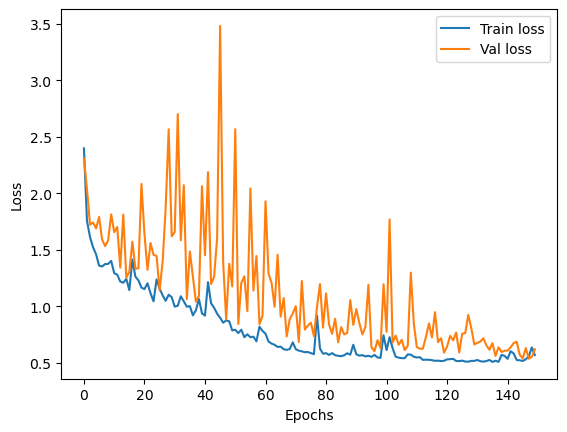

In [244]:
plt.plot(json_data['loss_train.json'], label='Train loss')
plt.plot(json_data['loss_val.json'], label='Val loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

The validation loss fluctuates a lot, suggesting an overfitting. It is important to check the IoU in order to verify that the model predicts well on data excluded from the training set, allowing us to find the optimum number of erosion iterations at the same time.

To do this, we plot the evolution of the IoU during training. I've added a regression to improve trend visibility (I hid the regression for the curves "Eroded three times" because it did not fit well).

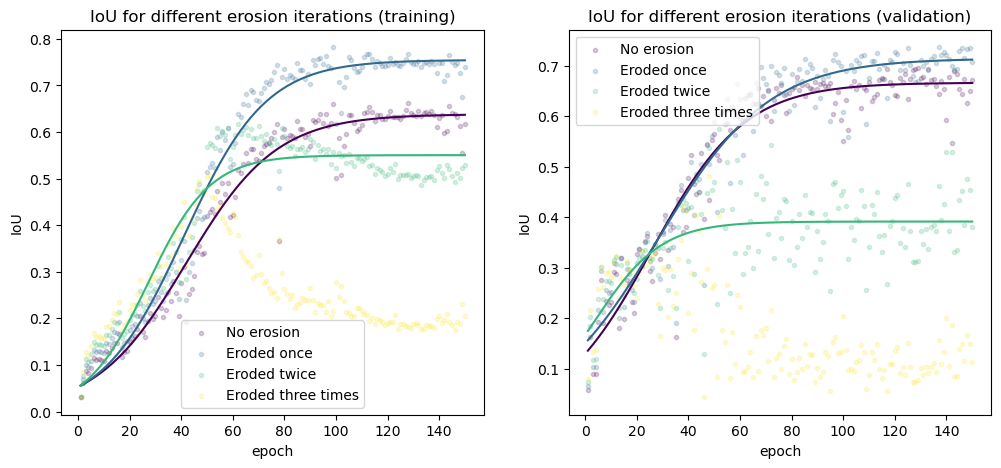

In [245]:
def logistic_reg(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

x = range(1, 151)

y_lists = [
    json_data['ero0_train.json'],  
    json_data['ero1_train.json'],  
    json_data['ero2_train.json'],
    json_data['ero3_train.json']
]

y_lists_val = [
    json_data['ero0_val.json'],  
    json_data['ero1_val.json'],  
    json_data['ero2_val.json'],
    json_data['ero3_val.json']
]

labels_list = ['No erosion', 'Eroded once', 'Eroded twice', 'Eroded three times']
colormap = plt.cm.viridis
colors = colormap(np.linspace(0, 1, len(y_lists)))

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
for i, y in enumerate(y_lists):
    params, _ = curve_fit(logistic_reg, x, y, p0=[1, np.median(x), 1], maxfev=2000)
    L, x0, k = params
    plt.scatter(x, y, label=labels_list[i], color=colors[i], alpha=0.2, marker='.')
    if i!=3:
        plt.plot(x, logistic_reg(x, L, x0, k), color=colors[i])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('IoU')
plt.title('IoU for different erosion iterations (training)')

plt.subplot(1,2,2)
for i, y in enumerate(y_lists_val):
    params, _ = curve_fit(logistic_reg, x, y, p0=[1, np.median(x), 1], maxfev=2000)
    L, x0, k = params
    plt.scatter(x, y, label=labels_list[i], color=colors[i], alpha=0.2, marker='.')
    if i!=3:
        plt.plot(x, logistic_reg(x, L, x0, k), color=colors[i])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('IoU')
plt.title('IoU for different erosion iterations (validation)')

plt.show()

Eroding the predicted mask once leads to the best IoUs, for both the training and the validation set. One the one hand, the training IoU tends to 0.75 whereas the validation IoU tends to 0.7; The model is slightly better on training dataset but still manages to predict masks from data excluded from the training set.

<span style="color:orange; font-weight:bold; font-size:30px;"> Model evaluation </span>

To visualize the results, as well as the impact of erosion, we can display a mask prediction based on an image from the test set.

In [246]:
model = torch.load('model_final.pth', map_location=torch.device('cpu'))

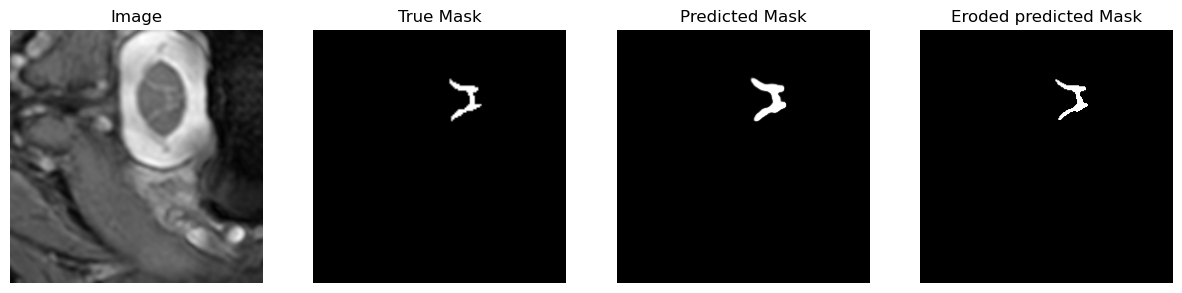

In [247]:
with torch.no_grad():
    for batch in test_loader:
        images, masks = batch
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)

        output_probs = torch.sigmoid(outputs)
        erod_masks1 = erode_masks(output_probs, iterations=1)
        
        fig, ax = plt.subplots(1, 4, figsize=(15, 5))
        ax[0].imshow(images[0].cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[0].set_title('Image')
        ax[0].axis('off')

        ax[1].imshow(masks[0].cpu().numpy(), cmap='gray')
        ax[1].set_title('True Mask')
        ax[1].axis('off')

        ax[2].imshow(output_probs[0][0].cpu().numpy(), cmap='gray')
        ax[2].set_title('Predicted Mask')
        ax[2].axis('off')

        ax[3].imshow(erod_masks1[0][0].cpu().numpy(), cmap='gray') 
        ax[3].set_title('Eroded predicted Mask')
        ax[3].axis('off')
        
        plt.show()
        break

On this example, we can see that the mask is predicted in the right place, without artifacts, and that the erosion is indeed beneficial: the raw prediction has coarse contours, whereas the eroded one looks very close to the actual mask.  

Finally, we can evaluate the model on the whole test set:

In [248]:
def evaluate_model(model, test_dataloader):
    model = model.eval()
    iou_list = []
    iou_ero_list = []
    with torch.no_grad():
        for batch_test in test_dataloader:
            images = batch_test[0].to(device)
            masks = batch_test[1].to(device)
            pred = model(images)
            pred_masks = (torch.sigmoid(pred) > 0.5).float()
            erod_masks = erode_masks(pred_masks, iterations=1)
            iou = compute_iou(pred_masks, masks)
            iou_ero = compute_iou(erod_masks, masks)
            iou_list.append(iou)
            iou_ero_list.append(iou_ero)
    print(f'Mean IoU on test dataset without erosion : {np.mean(iou_list) }')
    print(f'Mean IoU on test dataset with erosion (once) : {np.mean(iou_ero_list) }')

In [249]:
evaluate_model(model, test_loader)

Mean IoU on test dataset without erosion : 0.6441730317284289
Mean IoU on test dataset with erosion (once) : 0.7010369314229908


The mean IoU with eroded mask is 70.1%, which is close to the model's performance on the validation set. This value indicates that the segmentation model performs well, capturing a significant overlap between the predicted and actual regions.  
However, the IoU could be higher with further optimization. such as enhancing the model architecture or using more training data, applying advanced augmentation techniques, or fine-tuning hyperparameters like the learning rate and batch size might reduce prediction errors, especially around object boundaries. Another option would have been to consider a mean mask instead of a majority vote mask, but the imporvement would not be guaranteed.

<span style="color:blue; font-weight:bold; font-size:36px;"> Predictions </span>

The final stage of this project is to try to predict masks on new images. To do this, I saved three images in numpy array format, with different resolutions and orientations.

In [250]:
def predict_mask(model, mri_slice, iterations=1):
    min_val = mri_slice.min()
    max_val = mri_slice.max()
    normalized_image = 2 * (mri_slice - min_val) / (max_val - min_val) - 1
    mri_tensor = torch.Tensor(normalized_image).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        pred = model(mri_tensor)
    pred = (torch.sigmoid(pred) > 0.5)
    erod_mask = erode_masks(pred, iterations=iterations)
    return erod_mask[0][0]

I wrote a function allowing to overlap the predicted mask and the MRI slice in order to improve visualization.

In [251]:
def display_image_and_its_mask(img, mask):
    img_normalized = np.copy(img) / np.max(img)
    img_with_mask = np.copy(img_normalized)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if mask[x,y]==1:
                img_with_mask[x,y]=1
            else:
                pass
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(img_normalized, cmap='gray')
    plt.axis('off')
    plt.title('Base image')

    plt.subplot(1,2,2)
    plt.imshow(img_with_mask, cmap='gray')
    plt.axis('off')
    plt.title('Image with mask')

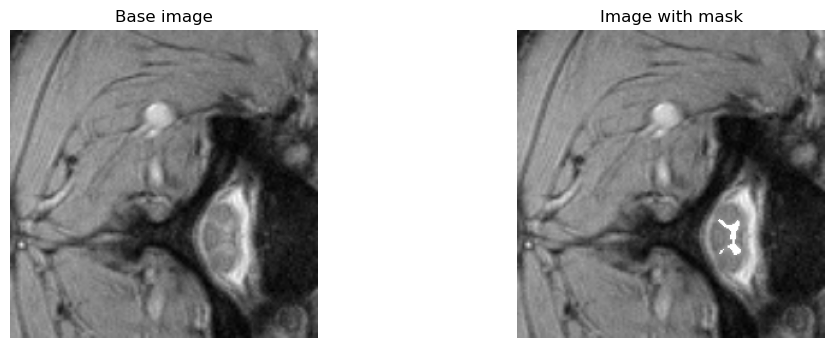

In [252]:
irm_test_path = 'test_samples/1.npy'
irm_test = np.load(irm_test_path)
predicted_mask = predict_mask(model, irm_test, iterations=1)
display_image_and_its_mask(irm_test, predicted_mask)

Here, we can observe that the mask is well localized, but one of the "horns" of the gray matter seems to be too much eroded. However, without erosion, the prediction is less accurate. This kind of issue might not be problmeatic, because one often focuses on the higher part of the gray matter, the aiGM (cf. figure in the introduction) since it is a key target in common neurodegenerative conditions.

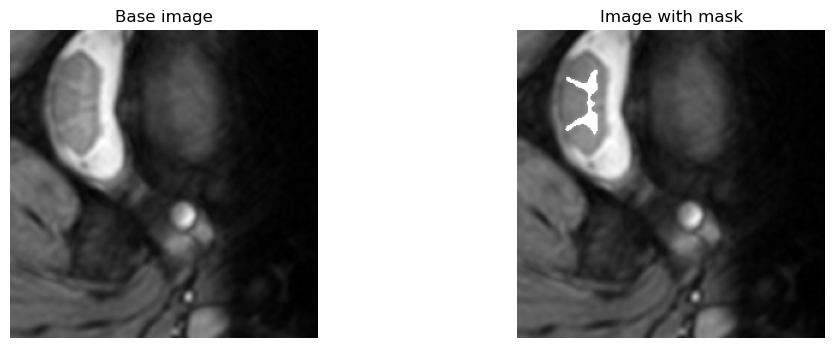

In [253]:
irm_test_path = 'test_samples/2.npy'
irm_test = np.load(irm_test_path)
predicted_mask = predict_mask(model, irm_test)
display_image_and_its_mask(irm_test, predicted_mask)

On this exemple, the gray matter is well predicted.

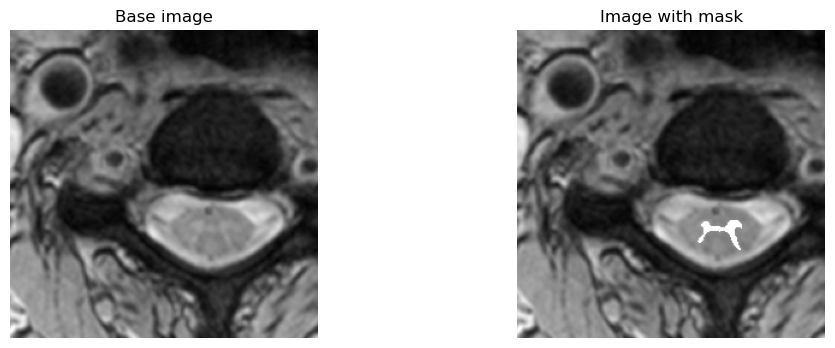

In [254]:
irm_test_path = 'test_samples/3.npy'
irm_test = np.load(irm_test_path)
predicted_mask = predict_mask(model, irm_test, iterations=1)
display_image_and_its_mask(irm_test, predicted_mask)

Finally, on this third exemple, the predicted mask is also well localized but this time, the upper left lobe seems too much eroded. However, the shape of the gray matter is still distinctive.

<span style="color:blue; font-weight:bold; font-size:36px;"> Conclusion </span>

The model allows us to predict gray matter location in spinal cord MRI with a good spatial accuracy, but could be improved in terms of boundary accuracy. We have to keep in mind that we used degraded quality images to train the model since we zoomed and resized the MRI around the gray matter. It involves that the model do not work on raw MRIs where the whole anatomy is imaged and the region of interest is smaller.

It would have been interesting to train the model on the raw dataset in order to see if it predicts well on complete MRIs. This approach has not been implemented here because of the various modalities of the dataset, and because the number of samples for each of these modalities may have been too small to obtain sufficient precision.

On the other hand, by preferring the approach in which I homogenized the data from the different sites, I had the opportunity to manipulate numerous tools relating to Pytorch, while ending up with a model with which I am satisfied and various knowledges acquired.